In [40]:
import numpy as np
import matplotlib.pyplot as plt

1. Реализовать вейвлет Морле, "Мексиканская шляпа" и Хаара во временном пространстве. Посмотреть спектр.

Морле: $e^{{-t^2}/{\alpha^2}} e^{i 2 \pi t}$

"Мексиканская шляпа": $(1 - t^2) * e^{-t^2 / 2}$

Хаара: $\begin{cases}
  1,  x \in [ 0, \frac{T}{2} ) \\
 -1, x \in [ \frac{T}{2}, 1 ) \\
  0,  otherwise \\
\end{cases}$

d:\Develop\Python310\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
d:\Develop\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


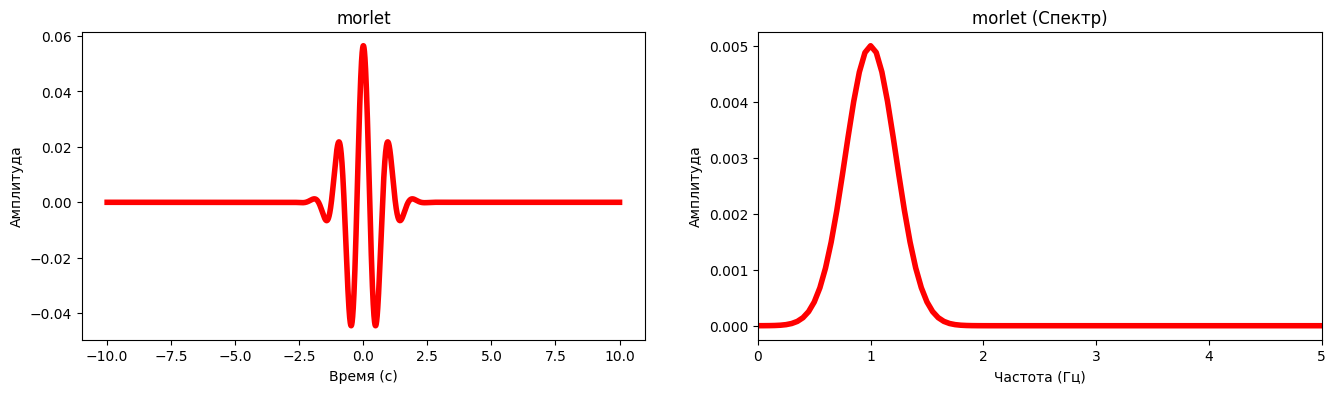

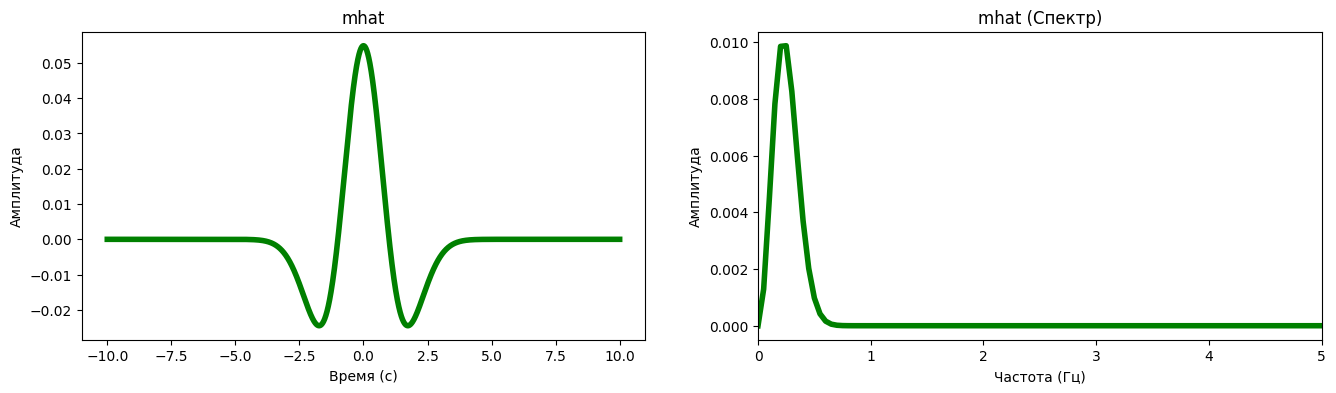

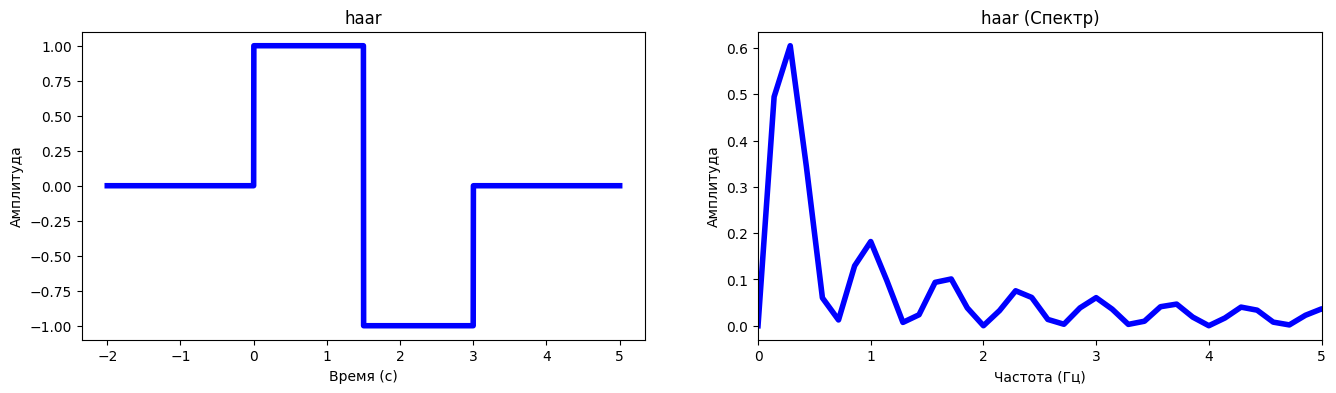

In [41]:
def wavelet_morlet(t, alpha=1.0, peak_freq=1.0):
    psi = np.exp(-t**2 / alpha**2) * np.exp(2j * np.pi * t * peak_freq)
    return psi / np.sqrt(np.sum(np.abs(psi)**2))  # Нормализация

def wavelet_mhat(t, peak_freq=0.0):
    psi = (1 - t**2) * np.exp(-t**2 / 2) * np.exp(2j * np.pi * t * peak_freq)
    return psi / np.sqrt(np.sum(np.abs(psi)**2))  # Нормализация

def wavelet_haar(t, T=1, shift=0, peak_freq=1.0):
    t_scaled = t * peak_freq
    return np.array([1 if (t_scaled >= shift) and (t_scaled < T/2 + shift) else -1 if (t_scaled >= T/2 + shift) and (t_scaled < T + shift)
                     else 0 for t_scaled in np.nditer(t_scaled)])

wavelets = {
    "morlet": {
        "func": wavelet_morlet,
        "num": 5000,
        "t": np.linspace(-10, 10, 5000),
        "name": 'morlet',
        "params": {"alpha": 1.0, "peak_freq": 1.0},
        "line_style": (5, (10, 3)),
        "line_width": 4,
        "color": "red"
    },
    "mhat": {
        "func": wavelet_mhat,
        "num": 5000,
        "t": np.linspace(-10, 10, 5000),
        "name": 'mhat',
        "params": {},
        "line_style": (0, (1, 1)),
        "line_width": 4,
        "color": "green"
    },
    "haar": {
        "func": wavelet_haar,
        "num": 5000,
        "t": np.linspace(-2, 5, 5000),
        "name": 'haar',
        "params": {"T": 3, "shift": 0},
        "line_style": "--",
        "line_width": 2,
        "color": "blue"
    },
}

for wavelet in wavelets.values():
    y = wavelet["func"](wavelet["t"], **wavelet["params"])
    freq = np.fft.rfftfreq(len(wavelet["t"]), d=(wavelet["t"][1]-wavelet["t"][0]))
    yff = np.fft.rfft(y)
    wavelet["y"] = y
    wavelet["freq"] = freq
    wavelet["yff"] = yff
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))
    axs[0].plot(wavelet["t"], y, linewidth=4, color=wavelet["color"])
    axs[0].set_title(wavelet["name"])
    axs[0].set_xlabel('Время (с)')
    axs[0].set_ylabel('Амплитуда')
    axs[1].plot(freq, np.abs(yff) / wavelet["num"] * 2, linewidth=4, color=wavelet["color"])
    axs[1].set_xlim(0, 5)
    axs[1].set_title(wavelet["name"] + " (Спектр)")
    axs[1].set_xlabel('Частота (Гц)')
    axs[1].set_ylabel('Амплитуда')
    plt.show()


2. Рассмотреть произвольный сигнал с шумом.

Реализовать свертку сигнала с вейвлетами Морле, вейвлетом “Мексиканская шляпа” и
вейвлетом Хаара.

Осуществить фильтрацию сигналов с помощью этих 3-х вейвлетов.

Отметить сильные и слабые стороны каждого из вейвлетов.

In [42]:
def add_noise(signal, noise_level=1):
    '''
    Добавление к сигналу гауссовского шума 
    '''
    return signal + np.random.normal(0, noise_level, signal.shape)

def cos_signal(t, f, A=1):
    '''
    Функция возвращает значение косинусоидального сигнала в заданный момент времени t.
    t - время, f - список частот сигнала, A - амплитуда сигнала.
    '''
    y = 0
    for i in f:
        w = 2 * np.pi * i
        y += A * np.cos(w * t)
    return y

num = 5000  # количество отсчетов
f = [2, 5, 15, 50]

# создание сигнала
t = np.linspace(0, 3, num)
y = cos_signal(t, f)
np.random.seed(40)
y_noised = add_noise(y, 3)

# fft
freq = np.fft.rfftfreq(len(t), d=(t[1]-t[0]))
yff_signal = np.fft.rfft(y_noised)

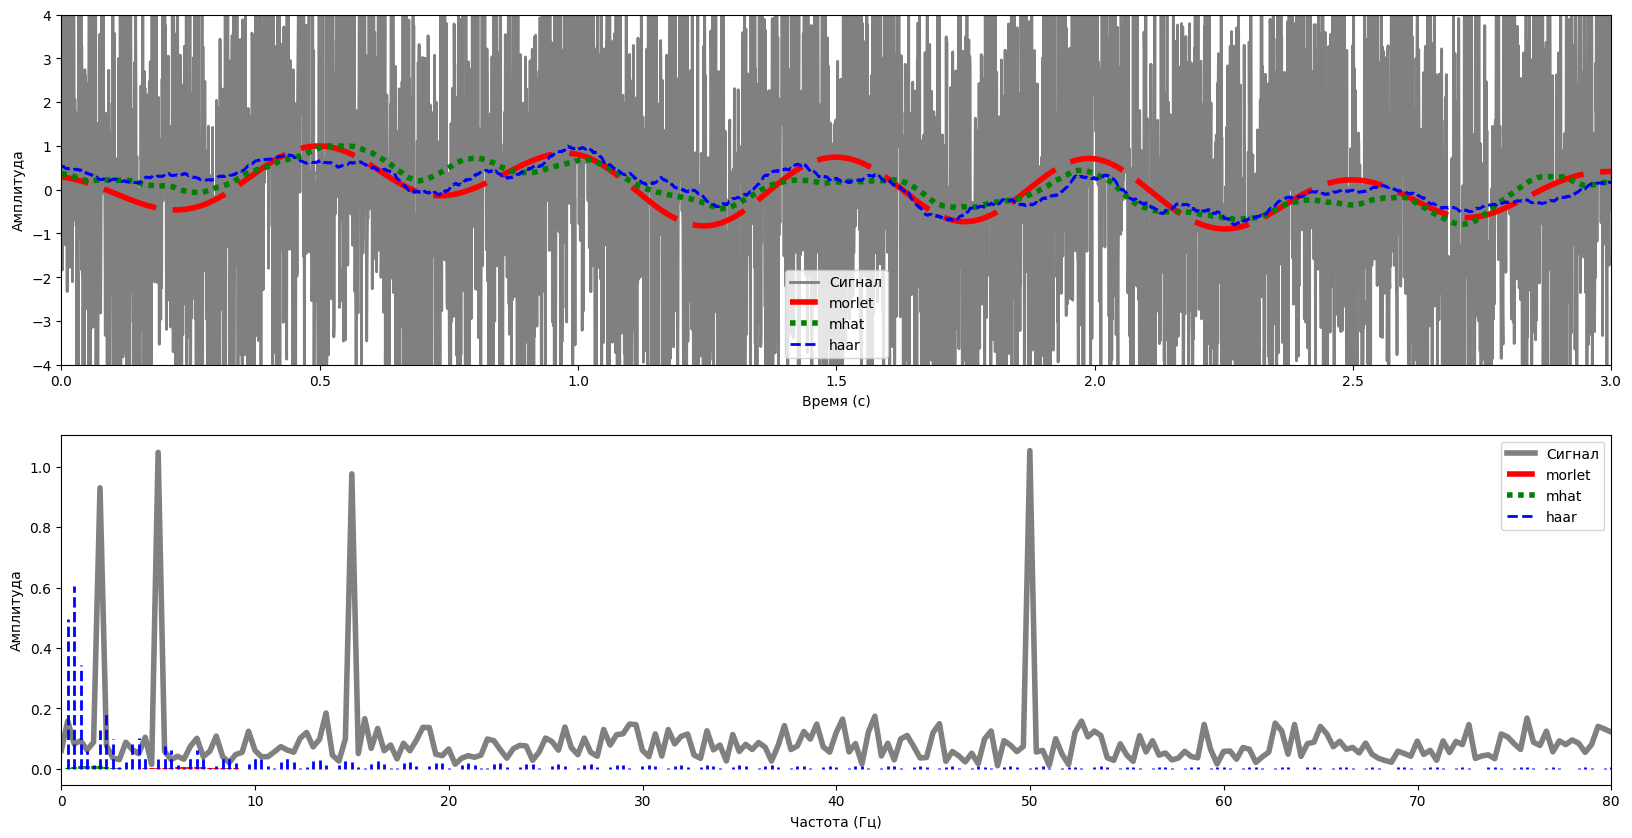

In [43]:
import scipy.signal
# wavelets apply
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(t, y_noised, linewidth=2, label='Сигнал', color="grey")
axs[0].set_xlabel('Время (с)')
axs[0].set_ylabel('Амплитуда')
axs[0].set_ylim(-4, 4)
axs[0].set_xlim(0, 3)
axs[1].plot(freq, np.abs(yff_signal) / num * 2, linewidth=4, label='Сигнал', color="grey")
axs[1].set_xlabel('Частота (Гц)')
axs[1].set_ylabel('Амплитуда')
axs[1].set_xlim(0, 80)

for i, wavelet in enumerate(wavelets.values()):
    filtered = (scipy.signal.convolve(y_noised, np.abs(wavelet["y"]), mode="same"))
    yff_morlet = np.fft.rfft(filtered)
    # plots
    k_scale = np.max(y_noised)
    axs[0].plot(t, filtered / np.max(filtered), label=wavelet['name'], color=wavelet["color"], linewidth=wavelet["line_width"], linestyle=wavelet["line_style"])
    axs[1].vlines(freq, 0, np.abs(wavelet['yff']) / wavelet['num'] * 2, color=wavelet['color'], label=wavelet['name'], linewidth=wavelet["line_width"], linestyle=wavelet["line_style"])

axs[0].legend()
axs[1].legend()
plt.show()

3. Приведен сигнал, частота которого меняется со временем и спектрограмма данного сигнала, которая получена в результате сверки
сигнала с вейвлетом Морле. Реализовать данный код. Разобраться в построении спектрограммы.

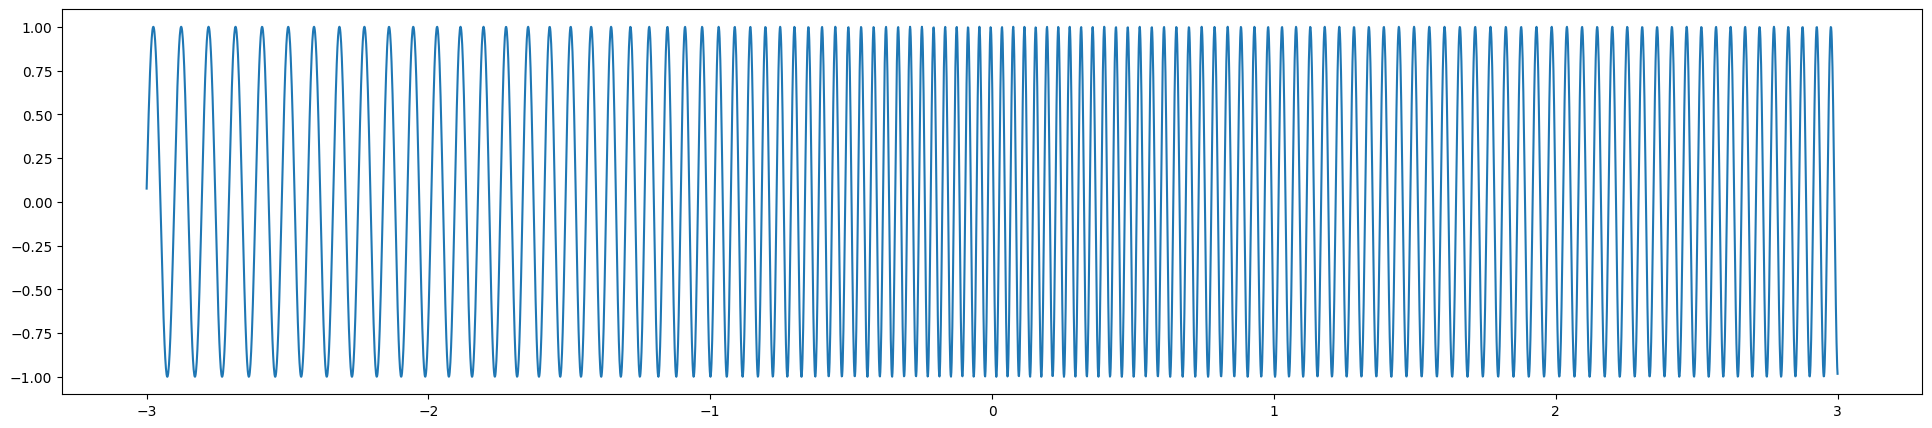

In [44]:
num = 5000
t = np.linspace(-3, 3, num)

# Смещение частот
freq_move = 10
# Сигнал обратной экспоненты, дополненный на отрицательную часть
freqmod = np.exp(-t**2) * 10 + freq_move
# Добавим линейный рост частот
freqmod += np.linspace(0, 10, num)

signal = np.sin(12 * np.pi * np.cumsum(freqmod) / num)

plt.subplots(1, 1, figsize=(24, 5))
plt.plot(t, signal)
plt.show()

In [45]:
# Перебираемые частоты вейвлетов
freqs_num = 100
freqs = np.linspace(5, 30, freqs_num)
fwhm = 0.17

# Пустой список для хранения вейвлетов
wavelets2 = []
# Цикл по всем частотам
for freq in freqs:
    wavelets2.append(wavelet_morlet(t, fwhm, freq))
# Преобразование списка в массив NumPy
wavelets2 = np.array(wavelets2)

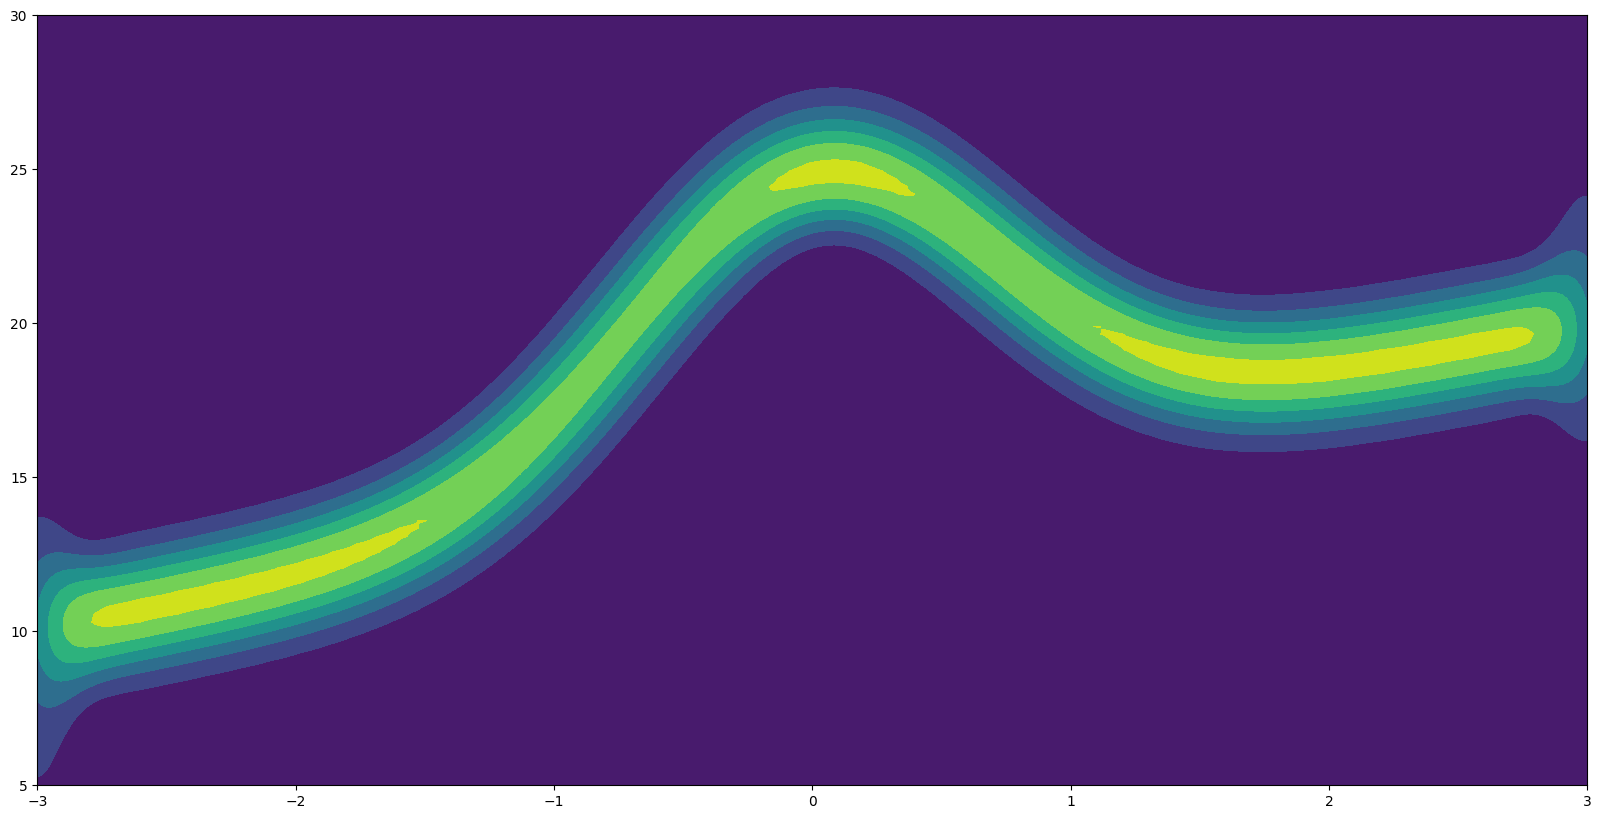

In [46]:
# Пустой список для хранения результатов свертки
tf2 = []
# Цикл по всем вейвлетам
for wavelet in wavelets2:
    # Свертка вейвлета и сигнала
    tf2.append(np.abs(scipy.signal.convolve(signal, wavelet, 'same')))
# Преобразование списка в массив NumPy
tf2 = np.array(tf2)

plt.figure(figsize=(20, 10))
plt.contourf(t, freqs, tf2)
plt.show()

4. Построить спектрограмму сигнала активности мозга (файл Lab6_Data.mat).
Использовать для реализации вейвлет Морле.

In [47]:
import scipy.io as sio
data = sio.loadmat('Lab6_Data.mat')
t3 = data['timevec'][0]
signal3 = data['data'][0]

In [48]:
# Перебираемые частоты вейвлетов
freqs_num3 = 150
freqs3 = np.linspace(8, 65, freqs_num3)
fwhm3 = 0.15

# Пустой список для хранения вейвлетов
wavelets3 = []
# Цикл по всем частотам
for freq in freqs3:
    wavelets3.append(wavelet_morlet(t3, fwhm3, freq))
# Преобразование списка в массив NumPy
wavelets3 = np.array(wavelets3)

In [49]:
# Пустой список для хранения результатов свертки
tf3 = []
# Цикл по всем вейвлетам
for wavelet in wavelets3:
    # Свертка вейвлета и сигнала
    tf3.append(np.abs(scipy.signal.convolve(signal3, wavelet, 'same')))
# Преобразование списка в массив NumPy
tf3 = np.array(tf3)


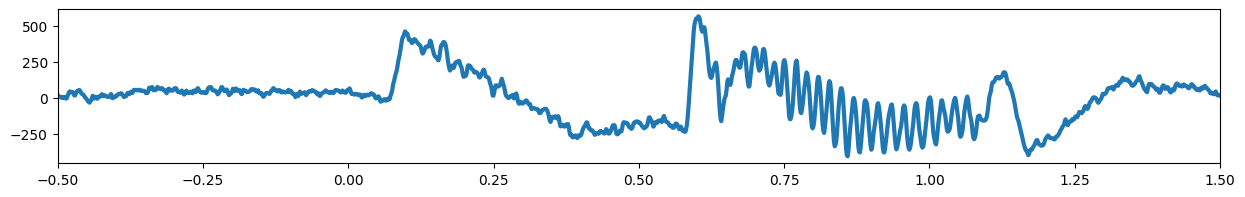

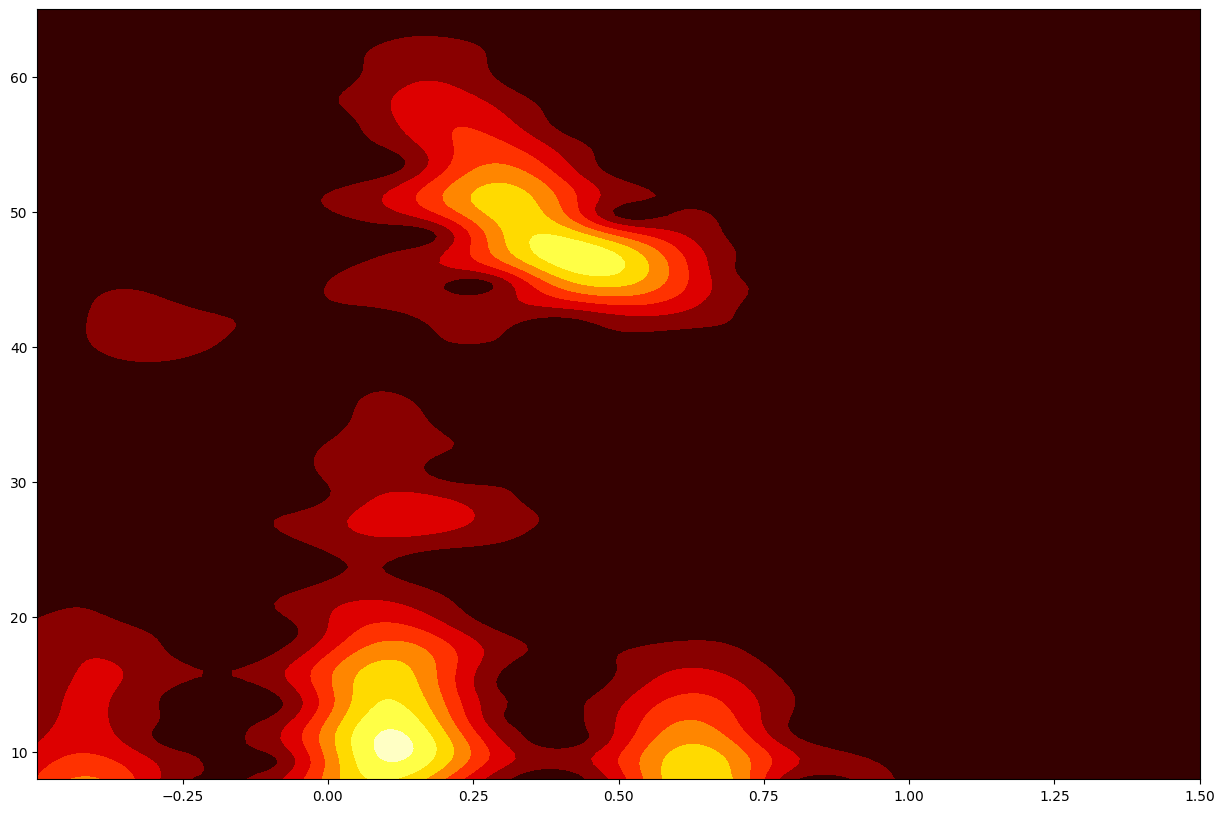

In [50]:
from matplotlib import cm
plt.figure(figsize=(15, 2))
plt.plot(t3, signal3, linewidth=3)
plt.xlim(-0.5, 1.5)
plt.show()

plt.figure(figsize=(15, 10))
plt.contourf(t3, freqs3, tf3, cmap=cm.hot)
plt.show()

5. Скачайте с интернета любой аудио
файл, постройте для него
спектрограмму используя вейвлет
Морле, вейвлет Хаара и вейвлет
"Мексиканская шляпа". Объясните
результаты.

In [51]:
import audio2numpy as a2n
signal_nokia, srate = a2n.audio_from_file("nokia start.mp3")
t_nokia = np.linspace(0, 1, num=len(signal_nokia))

In [52]:
# Перебираемые частоты вейвлетов
freqs_num_nokia = 100
freqs_nokia = np.linspace(5, 30, freqs_num_nokia)
fwhm_nokia = 0.15

# Пустой список для хранения вейвлетов
wavelets_nokia = []
# Цикл по всем частотам
for freq in freqs_nokia:
    wavelets_nokia.append(wavelet_morlet(t_nokia, fwhm_nokia, freq))

wavelets_nokia = np.array(wavelets_nokia)

In [53]:
# Пустой список для хранения результатов свертки
tf_nokia = []
# Цикл по всем вейвлетам
for wavelet in wavelets_nokia:
    # Свертка вейвлета и сигнала
    tf_nokia.append(np.abs(scipy.signal.convolve(signal_nokia, wavelet, 'same')))

tf_nokia = np.array(tf_nokia)


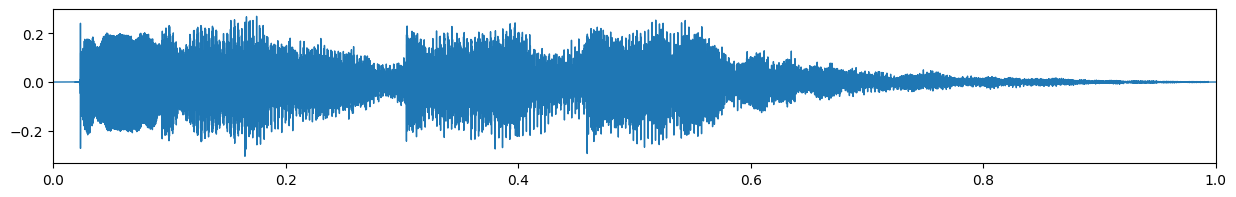

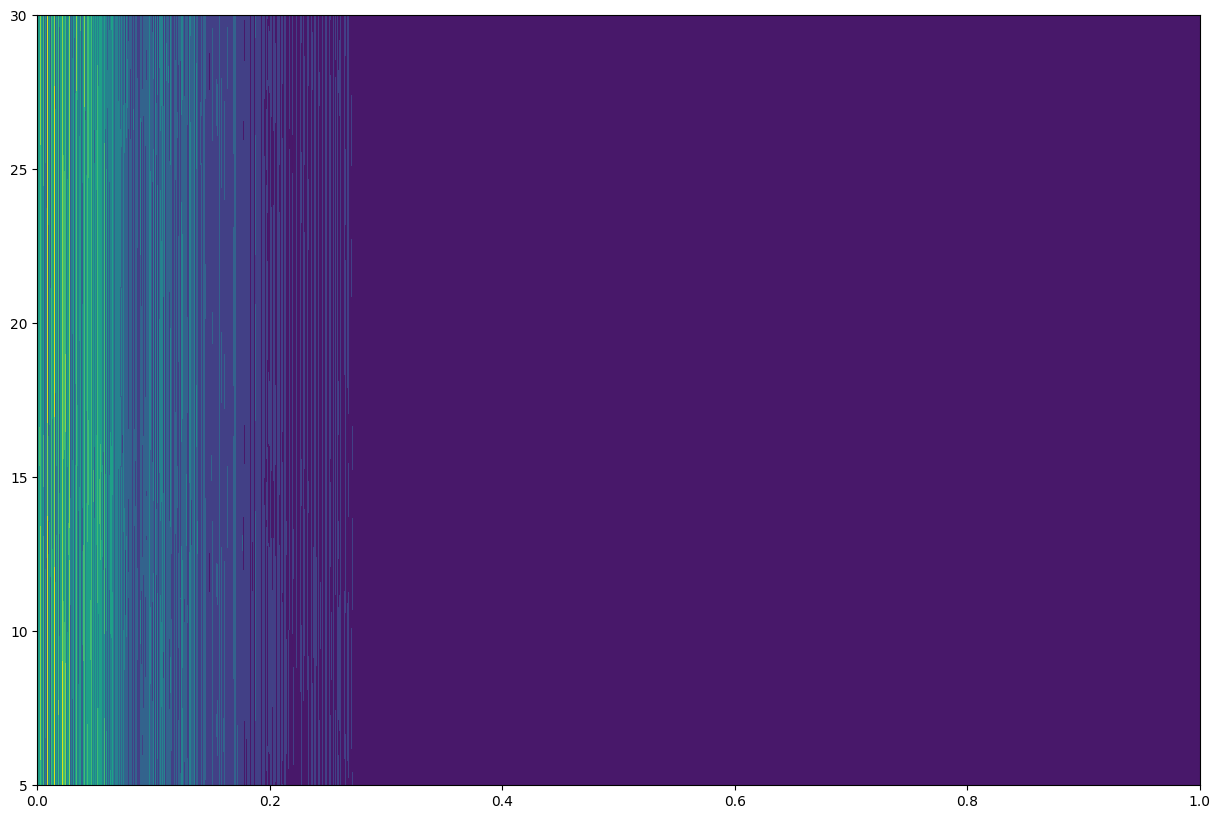

In [54]:
plt.figure(figsize=(15, 2))
plt.plot(t_nokia, signal_nokia, linewidth=1)
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(15, 10))
plt.contourf(t_nokia, freqs_nokia, tf_nokia)
plt.show()

In [55]:
signal_mi, srate = a2n.audio_from_file("mi_1_okt.mp3")
t_mi = np.linspace(0, 1, num=len(signal_mi))

In [64]:
# Перебираемые частоты вейвлетов
freqs_num_mi = 100
freqs_mi = np.linspace(-45, 45, freqs_num_mi)
fwhm_mi = 0.15

# Пустой список для хранения вейвлетов
wavelets_mi = []
# Цикл по всем частотам
for freq in freqs_mi:
    wavelets_mi.append(wavelet_morlet(t_mi, fwhm_mi, freq))

wavelets_mi = np.array(wavelets_mi)

In [65]:
# Пустой список для хранения результатов свертки
tf_mi = []
# Цикл по всем вейвлетам
for wavelet in wavelets_mi:
    # Свертка вейвлета и сигнала
    tf_mi.append(np.abs(scipy.signal.convolve(signal_mi, wavelet, 'same')))

tf_mi = np.array(tf_mi)


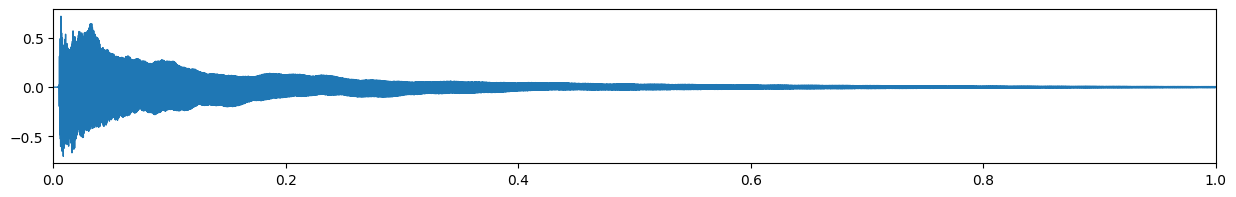

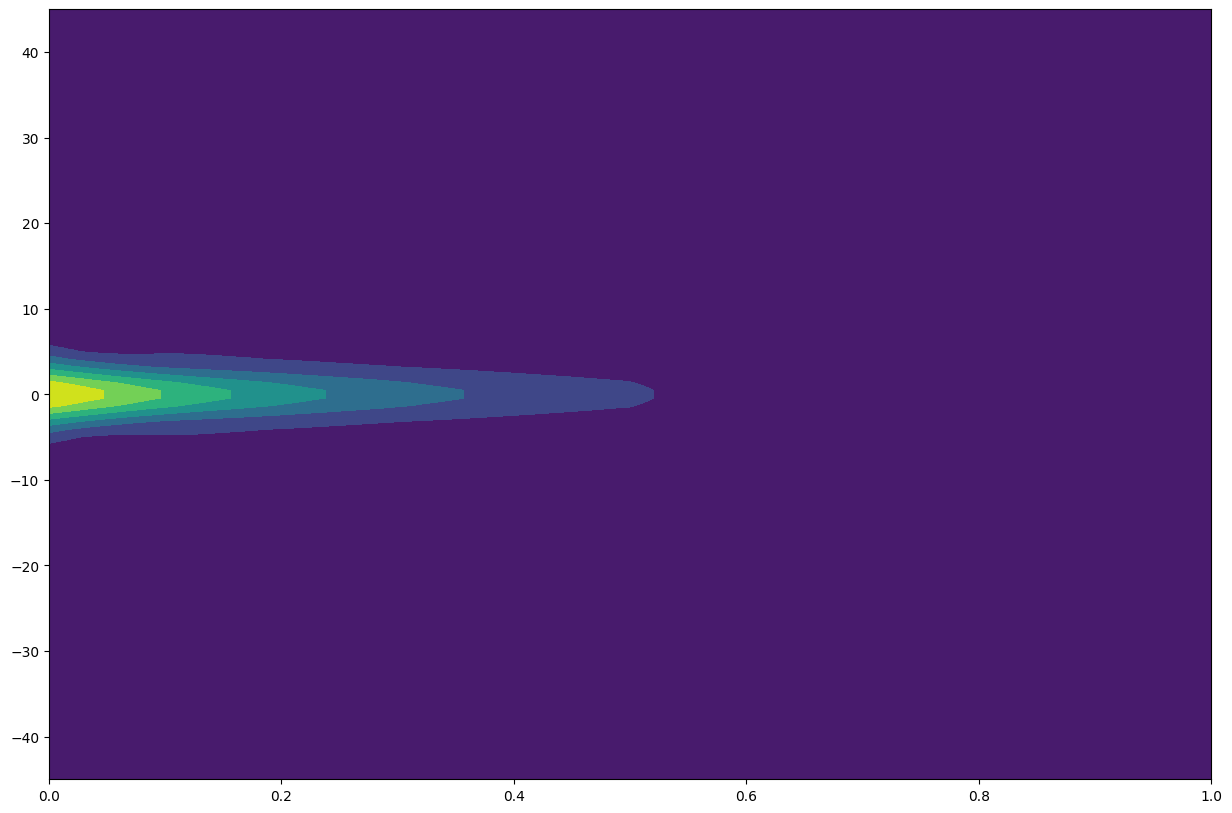

In [66]:
plt.figure(figsize=(15, 2))
plt.plot(t_mi, signal_mi, linewidth=1)
plt.xlim(0, 1)
plt.show()

plt.figure(figsize=(15, 10))
plt.contourf(t_mi, freqs_mi, tf_mi)
plt.show()

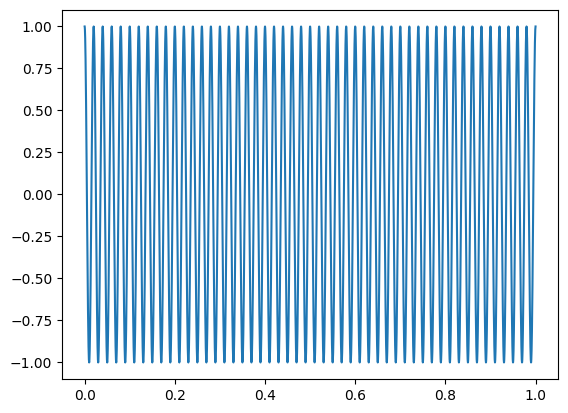

In [59]:
num = 5000  # количество отсчетов
f = [50]

# создание сигнала
t_cos50 = np.linspace(0, 1, num)
signal_cos50 = cos_signal(t_cos50, f)
plt.plot(t_cos50, signal_cos50)
plt.show()

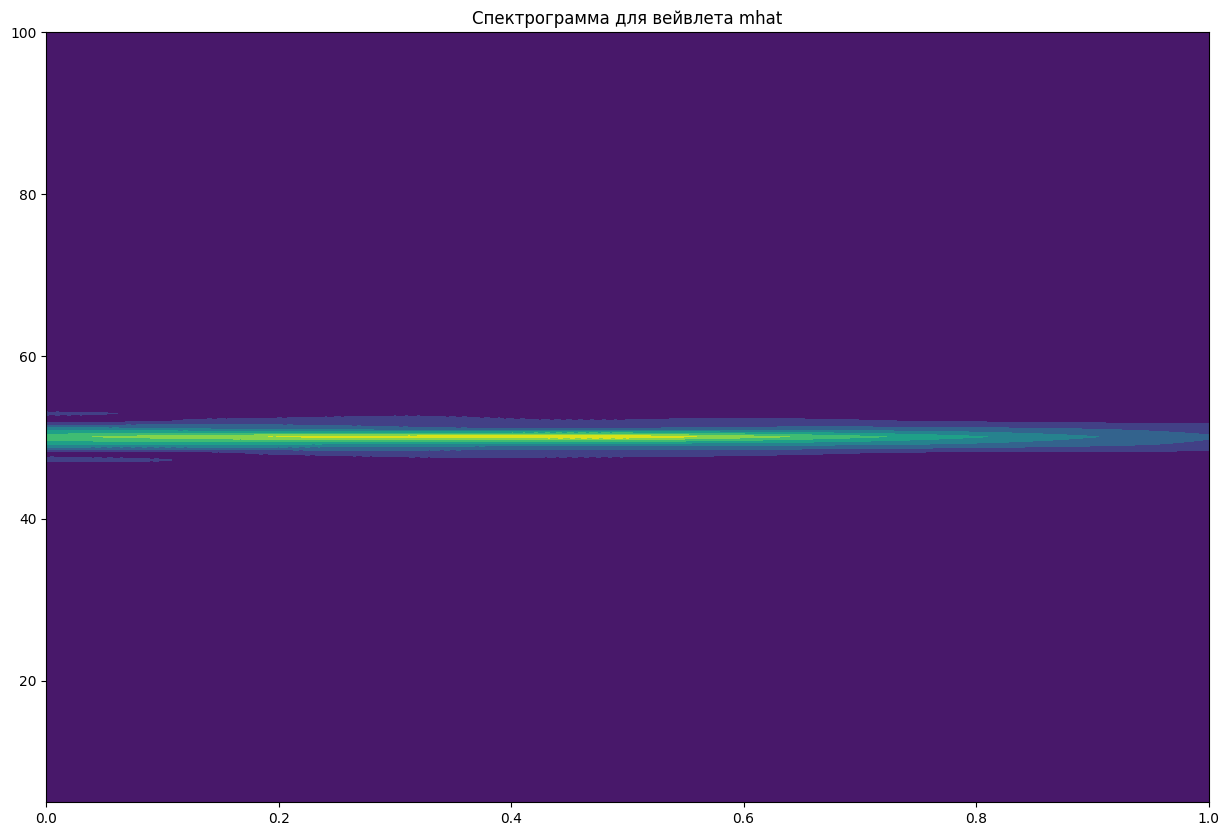

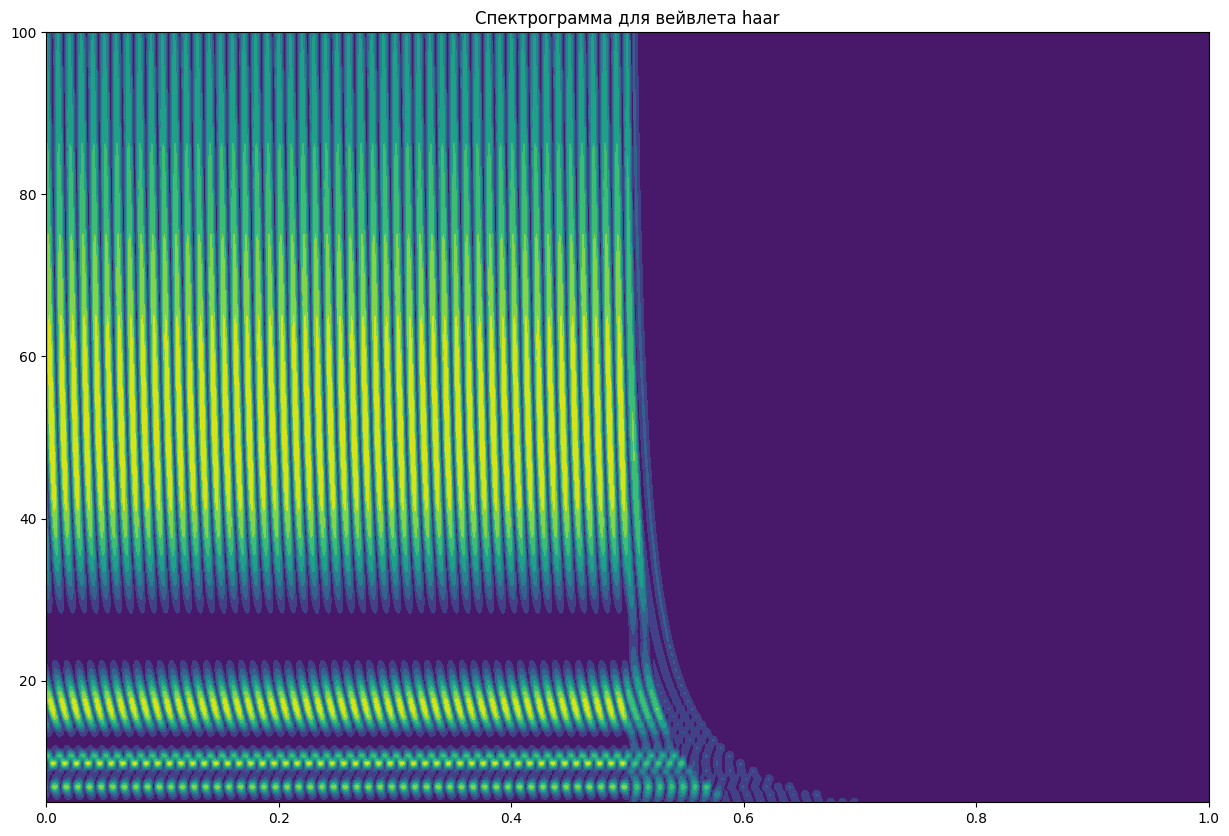

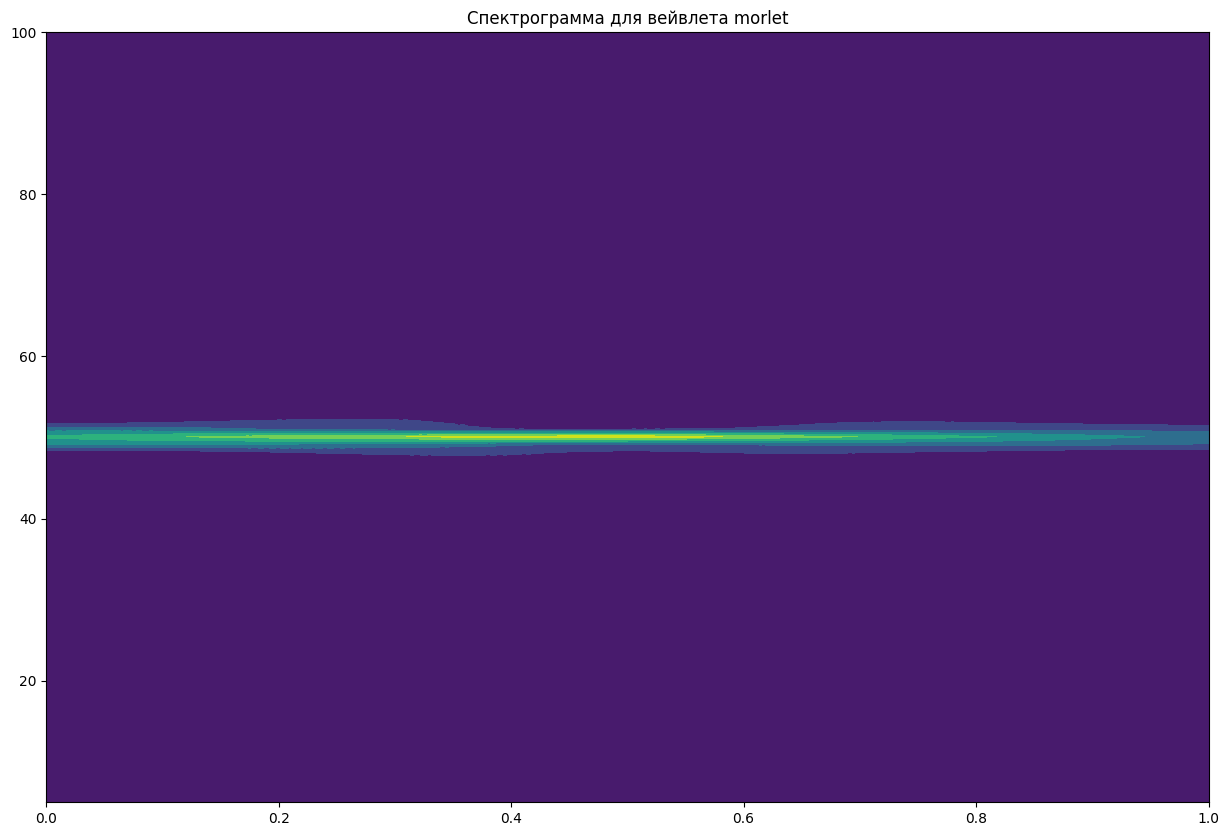

In [63]:
# Словарь вейвлетов
wavelet_dict = {'mhat': wavelet_mhat, 'haar': wavelet_haar, 'morlet': wavelet_morlet}

# Перебираемые частоты вейвлетов
freqs_num_cos50 = 100
freqs_cos50 = np.linspace(5, 100, freqs_num_cos50)

# Цикл по всем вейвлетам в словаре
for wavelet_name, wavelet_func in wavelet_dict.items():
    # Пустой список для хранения вейвлетов
    wavelets_cos50 = []
    # Цикл по всем частотам
    for freq in freqs_cos50:
        wavelets_cos50.append(wavelet_func(t_cos50, peak_freq=freq))

    wavelets_cos50 = np.array(wavelets_cos50)

    # Пустой список для хранения результатов свертки
    tf_cos50 = []
    # Цикл по всем вейвлетам
    for wavelet in wavelets_cos50:
        # Свертка вейвлета и сигнала
        tf_cos50.append(np.abs(scipy.signal.convolve(signal_cos50, wavelet, 'same')))

    tf_cos50 = np.array(tf_cos50)

    plt.figure(figsize=(15, 10))
    plt.title(f'Спектрограмма для вейвлета {wavelet_name}')
    plt.contourf(t_cos50, freqs_cos50, tf_cos50)
    plt.show()
